In [32]:
import torch
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from random import randint

In [33]:
#Les fonctions dans ce bloc ne sont pas utilisées par le réseau, mais certaines fonctions d'outils

#    Cette fonction convertit l'image en variable de type Tensor.
#    Toutes les données de calcul du réseau sont de type Tensor
#    Img.shape=[Height,Width,Channel]
#    Tensor.shape=[Batch,Channel,Height,Width]
def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

#   Trouvez les coordonnées de la valeur maximale dans une carte de corrélation
#   x,y=show_coordonnee(carte de corrélation)
def show_coordonnee(position_pred):
    map_corre=position_pred.squeeze().detach().cpu().numpy()
    h,w=map_corre.shape
    max_value=map_corre.max()
    coordonnee=np.where(map_corre==max_value)
    return coordonnee[0].mean(),coordonnee[1].mean()
    
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

def kernel_add_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n/2)*int(m/2)
    for i in range(int(n/2)):
        for j in range(int(m/2)):
            kernel_add=np.zeros([1,input_canal],dtype='float32')
            kernel_add[0,i*2*m+j*2]=1
            kernel_add[0,i*2*m+j*2+1]=1
            kernel_add[0,(i*2+1)*m+j*2]=1
            kernel_add[0,(i*2+1)*m+j*2+1]=1
            if i==0 and j==0:
                add=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
            else:
                add_=torch.from_numpy(kernel_add.reshape(1,input_canal,1,1))
                add=torch.cat((add,add_),0)
    return torch.nn.Parameter(add,requires_grad=False) 

def kernel_shift_ini(n,m):
    input_canal=int(n*m)
    output_canal=int(n*m)
    
    kernel_shift=torch.zeros([output_canal,input_canal,3,3])
    
    array_0=np.array([[1,0,0],[0,0,0],[0,0,0]],dtype='float32')
    array_1=np.array([[0,0,1],[0,0,0],[0,0,0]],dtype='float32')
    array_2=np.array([[0,0,0],[0,0,0],[1,0,0]],dtype='float32')
    array_3=np.array([[0,0,0],[0,0,0],[0,0,1]],dtype='float32')
    
    kernel_shift_0=torch.from_numpy(array_0)
    kernel_shift_1=torch.from_numpy(array_1)
    kernel_shift_2=torch.from_numpy(array_2)
    kernel_shift_3=torch.from_numpy(array_3)
    
    
    for i in range(n):
        for j in range(m):
            if i==0 and j==0:
                kernel_shift[0,0,:]=kernel_shift_0
            else:
                if i%2==0 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_0
                if i%2==0 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_1
                if i%2==1 and j%2==0:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_2
                if i%2==1 and j%2==1:
                    kernel_shift[i*m+j,i*m+j,:]=kernel_shift_3
                    
    return torch.nn.Parameter(kernel_shift,requires_grad=False) 

#   Trouvez le petit patch(4 * 4) dans la n ème ligne et la m ème colonne du patch d'entrée
#   Ceci est utilisé pour calculer la convolution et obtenir la carte de corrélation
def get_patch(fragment,psize,n,m):
    return fragment[:,:,n*psize:(n+1)*psize,m*psize:(m+1)*psize]
###################################################################################################################

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #n*m patches
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1)
        #self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
        
        
    def get_descripteur(self,img,using_cuda):
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img
    
    def forward(self,img,frag,using_cuda):
        psize=4
        
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        #shift
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        c1 = map_corre.data.numpy()
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
            
        c2 = map_corre.data.numpy()
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        map_corre=map_corre/(map_corre.max())
        #map_corre=(F.softmax(map_corre.reshape(1,1,h*w,1),dim=2)).reshape(b,c,h,w)
        return c1,c2,map_corre.data.numpy()

In [28]:
cartes_filename = './trained_net/cartes_correlations_NOMB_02-15_01-37_0043'

with open(cartes_filename,'rb') as pkl_file:
    cartes = pickle.load(pkl_file)

cartes1 = cartes['carte1']
cartes2 = cartes['carte2']
cartes3 = cartes['carte3']

N = 20
c1 = cartes1[N][0,0,:,:]
c2 = cartes2[N][0,0,:,:]
c3 = cartes3[N][0,0,:,:]


In [9]:
base_dir                 = './training_data_32/'
fresque_filename         = base_dir+'fresque_small{}.ppm'
fresque_filename_wild    = base_dir+'fresque_small*.ppm'
fragment_filename        = base_dir+'fragments/fresque{}/frag_dev_{:05}.ppm'
fragments_filename_wild  = base_dir+'fragments/fresque{}/frag_bench_*.ppm'
vt_filename              = base_dir+'fragments/fresque{}/vt/frag_bench_{:05}_vt.txt'
net_filename             = "./trained_net/net_trainned_SLLShift_E3_03-10_21-02_0007"
fresque_id = randint(0,5)
fragment_id = randint(0,3000)
frag_size=32

print("Fresque {}, fragment {}".format(fresque_id,fragment_id))

frag = cv2.imread(fragment_filename.format(fresque_id,fragment_id))
frag_tensor=img2tensor(frag)

fresque = cv2.imread(fresque_filename.format(fresque_id))
fresque_tensor=img2tensor(fresque)

net = load_net(net_filename)
net.cpu()

carte1,carte2,carte3=net.forward(fresque_tensor,frag_tensor,using_cuda=False)
print("Done.")

Fresque 1, fragment 2956


FileNotFoundError: [Errno 2] No such file or directory: './trained_net/net_trainned_NOMB_E3_02-23_07-23_0007'

<IPython.core.display.Javascript object>


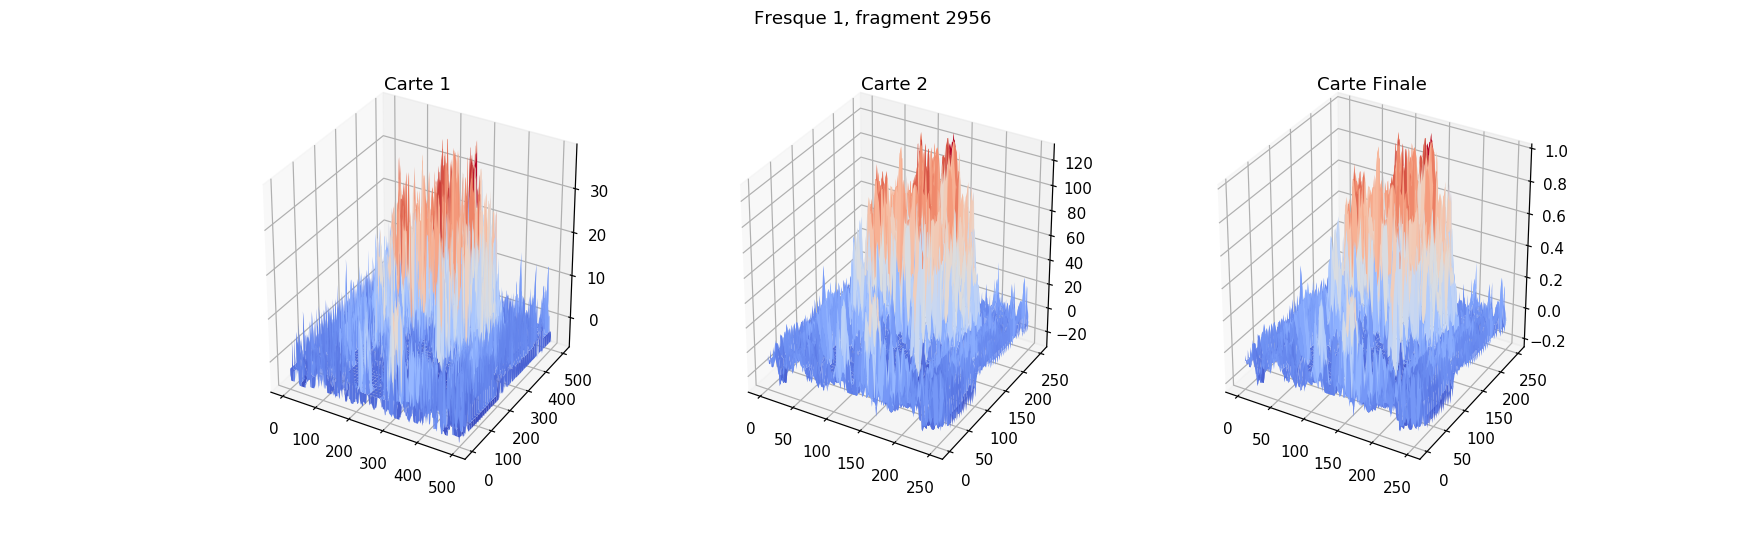

Shapes: c1:(501, 501), c2:(251, 251), c3:(251, 251)


In [29]:
#c1,c2,c3= carte1[0,0,:,:],carte2[0,0,:,:],carte3[0,0,:,:]


fig = plt.figure(figsize=(16,5))


print("Shapes: c1:{}, c2:{}, c3:{}".format(c1.shape,c2.shape,c3.shape))


ab = np.arange(0,c1.shape[0],1)
ordo = np.arange(0,c1.shape[1],1)
xx,yy = np.meshgrid(ab,ordo)
ax1 = fig.add_subplot(1,3,1,projection='3d')
ax1.plot_surface(xx,yy,c1,cmap=cm.coolwarm,linewidth=0)
ax1.set_title("Carte 1")

ab = np.arange(0,c2.shape[0],1)
ordo = np.arange(0,c2.shape[1],1)
xx,yy = np.meshgrid(ab,ordo)
ax2 = fig.add_subplot(1,3,2,projection='3d')
ax2.plot_surface(xx,yy,c2,cmap=cm.coolwarm,linewidth=0)
ax2.set_title("Carte 2")

ab = np.arange(0,c3.shape[0],1)
ordo = np.arange(0,c3.shape[1],1)
xx,yy = np.meshgrid(ab,ordo)
ax3 = fig.add_subplot(1,3,3,projection='3d')
ax3.plot_surface(xx,yy,c3,cmap=cm.coolwarm,linewidth=0)
ax3.set_title("Carte Finale")

fig.suptitle("Fresque {}, fragment {}".format(fresque_id,fragment_id))

plt.show()

## Affichage de la fresque aprés passage du descripteur

In [29]:
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

def img2tensor(im):
    im=np.array(im,dtype="float32")
    tensor_cv = torch.from_numpy(np.transpose(im, (2, 0, 1)))
    im_tensor=tensor_cv.unsqueeze(0)
    return im_tensor

## Affichage pour 4 couches

<IPython.core.display.Javascript object>


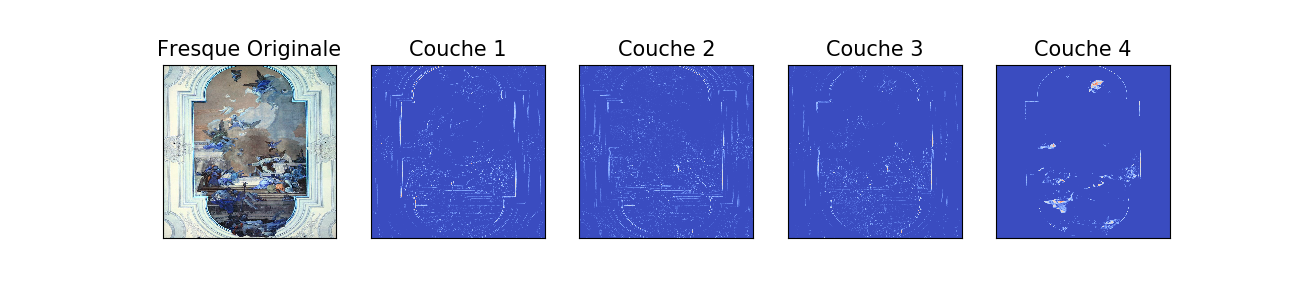

In [28]:
model_filename = "./trained_net/net_trainned_SLLShift_E3_03-10_21-02_0007"
fresque_filename = "./training_data_32/fresque5.ppm"
net = load_net(model_filename)
net = net.cpu()
fresque = cv2.imread(fresque_filename)
fresque_tensor = img2tensor(fresque)

#descripteur = net.get_descripteur(fresque,False).detach().numpy()
#descripteur_img=self.Relu(self.conv1(img))
desc = net.Relu(net.conv1(fresque_tensor)).detach().numpy()

fig = plt.figure(figsize=(13,3))

fs = 15
ax = fig.add_subplot(1,5,1)
ax.set_title("Fresque Originale",fontsize = fs)
ax.set_yticks([])
ax.set_xticks([])
ax.imshow(fresque)

for i in range(4):
    ax = fig.add_subplot(1,5,i+2)
    ax.set_title("Couche {}".format(i+1),fontsize = fs)
    ax.set_yticks([])
    ax.set_xticks([])
    ax = plt.imshow(desc[0,i,:,:],cmap=cm.coolwarm)
    #axs[i].set_title("Couche {}".format(i))

fig.savefig("features_4_shift.png",figsize=(20,8))
fig.show()

## Affichage pour 8 Couche

<IPython.core.display.Javascript object>


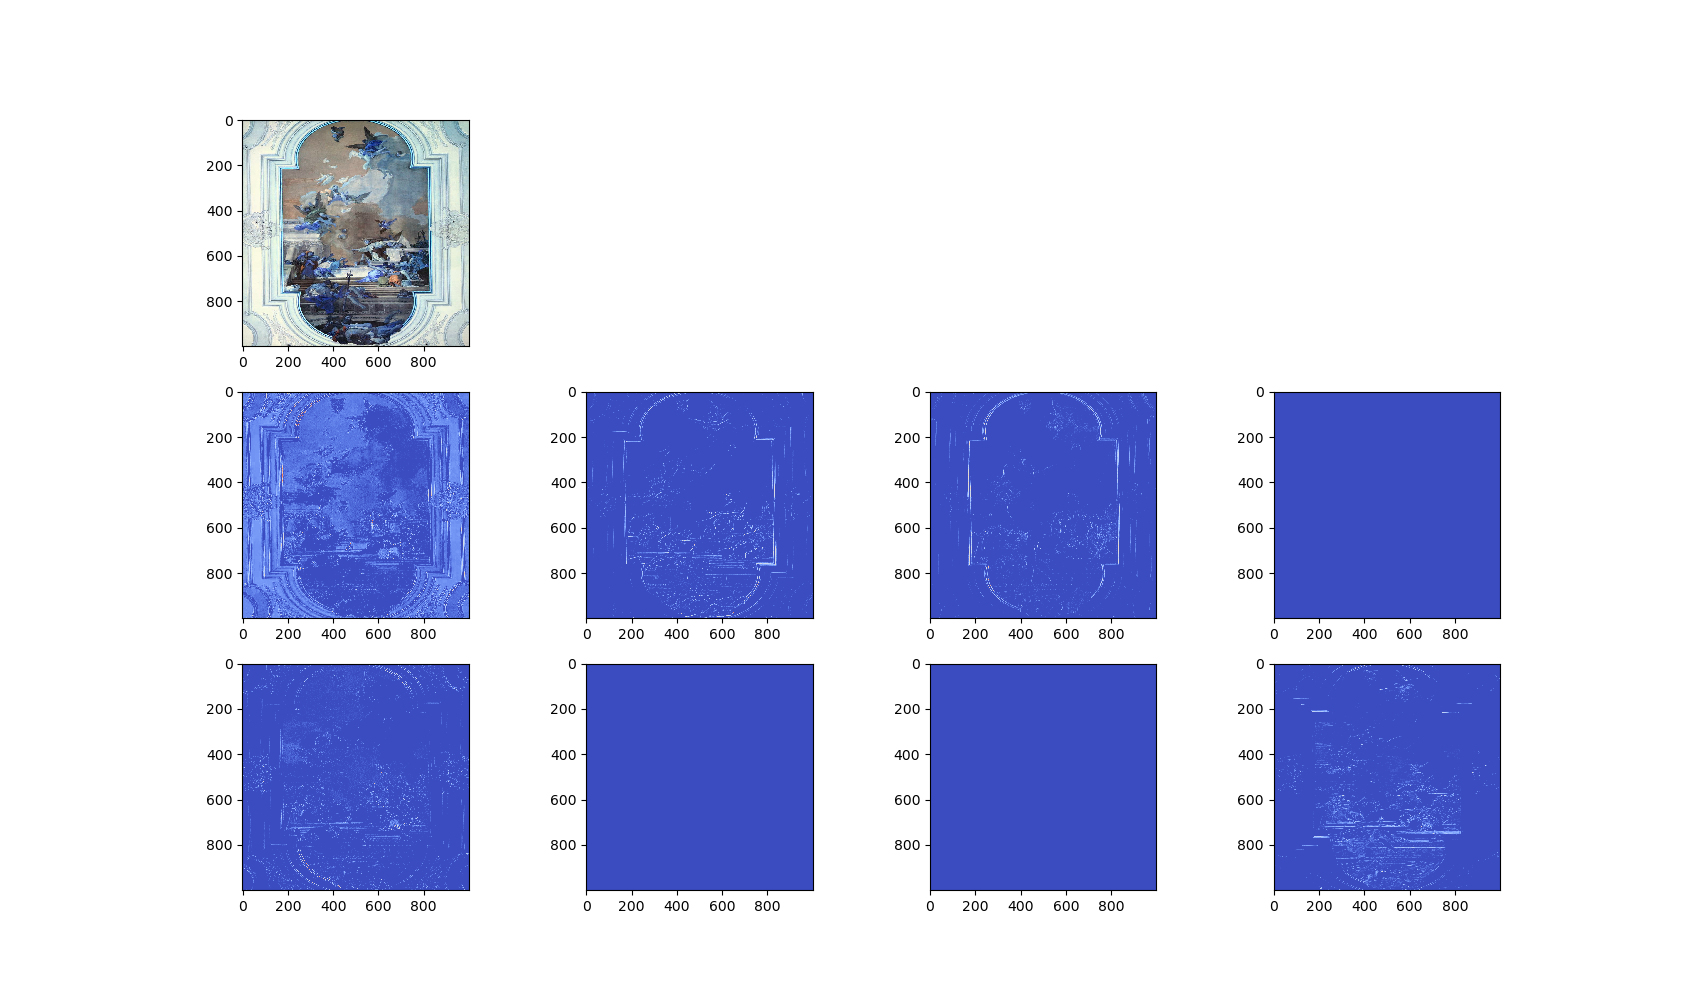

In [40]:
model_filename = "./trained_net/net_trainned_SLLShift_E3_03-11_17-34_0120"
fresque_filename = "./training_data_32/fresque5.ppm"
net = load_net(model_filename)
net = net.cpu()
fresque = cv2.imread(fresque_filename)
fresque_tensor = img2tensor(fresque)

#descripteur = net.get_descripteur(fresque,False).detach().numpy()
#descripteur_img=self.Relu(self.conv1(img))
desc = net.Relu(net.conv1(fresque_tensor)).detach().numpy()

fig = plt.figure(figsize=(17,10))

ax = fig.add_subplot(3,4,1)
ax.imshow(fresque)

for row in range(2):
    for i in range(4):
        ax = fig.add_subplot(3,4,i+5+(row*4))
        ax = plt.imshow(desc[0,i+row*4,:,:],cmap=cm.coolwarm)
        #axs[i].set_title("Couche {}".format(i))
    
fig.show()